## Code for testing the influence of different shapes on the K function.

In [339]:
import os
from time import time
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from scipy.fft import fft, ifft
from numpy.fft import fft, ifft, fft2, ifft2, fftshift

# scikit-image
from skimage import io
from tifffile import TiffFile
from skimage import filters
from scipy import signal

In [340]:

#-----------------------------------------
# using auto-correlation in Fourier space
#-----------------------------------------


def is_even(number):
    """
    Checks if integer number is even.
    """
    if int(number)!=number: 
        print("Error! Input can only be of type int!")
        return
    return int(number/2) == number/2


def distance_arr(arr):
    """
    Computes array whose elements are equal to their Euclidean distance from the center.
    """
    dimx, dimy = arr.shape
    # array should have equal dimensions, dimension should be odd
    if (dimx != dimy) or is_even(dimx):
        print("Error! Array has wrong shape!")
        return
        
    half_dim = int((dimx-1)/2)
    x_range = list(range(1,half_dim+1))
    line = x_range[::-1] + [0] + x_range 

    # array where every element is x distance from center
    diff_x = np.array([line, ]*dimx)
        
    # array where every element is y distance from center
    diff_y = diff_x.T
        
    # compute array whose elements are equal to their Euclidean distance from the center
    diff_xy = np.sqrt(diff_x**2 + diff_y**2)
    
    return diff_xy
    

def cut_circle(arr, radius, diff_xy):
    """
    Takes a 2D array and sets all elements outside a circle (around center of image) with specified radius to zero. 
    """
    mask = np.ones(arr.shape)
    mask[diff_xy>radius] = 0
    return arr * mask


def auto_correlation_fft(img):
    """
    Fast computation of auto-correlation using FFT.
    """
    dimx, dimy = img.shape
    # zero-padding of the input image
    img_for_fft = np.pad(img, (int(dimx/2),int(dimx/2)), 'constant', constant_values=(0, 0))

    # transform into Fourier space using fft
    # => auto-correlation is ifft of product of transformed image multiplied by its conjugate
    ft = fft2(img_for_fft)
    cc = np.real(ifft2(ft * ft.conj()))
    cc_image = fftshift(cc)
    corr_fft = cc_image.real[1:,1:]
    return corr_fft


def test_auto_correlation_fft():
    """
    Compares fft-based auto-corr. with auto-corr. in real space.
    """
    # compute arbitrary test image
    test_img = np.ones((20,20))
    test_img[10:15, 10:14] = 4
    test_img[11:12, 11:13] = 10
    
    corr = signal.correlate(test_img, test_img)
    corr_fft = auto_correlation_fft(test_img)
    
    # we require equivalence except for small numerical errors
    diff[diff<0.001] = 0
    
    assert np.unique(diff).item() == 0
    
    
def ripleys_K_fast(img_arr, range_of_t, lambda_):
    """
    Computes Ripley's K function for a range of t. Utilizes FFT for fast computation of auto-correlation of the image.
    """
    K_values = []
    
    # assure datatype that does not cause errors
    arr = img_arr.astype('float32')
    # number of pixels in desired area
    N = (arr>0).sum()
    
    t1 = time()
    
    # full array for the auto-correlation of the input image
    # own implementation:
    full_auto_corr = auto_correlation_fft(arr)
    # library function:
    #full_auto_corr = signal.correlate(arr,arr, method='fft')
    
    # array whose elements are equal to their Euclidean distance from the center
    diff_xy = distance_arr(full_auto_corr)

    for t in range_of_t:
        # array containing the auto-correlation up to distance t
        auto_corr_t = cut_circle(full_auto_corr, radius=t, diff_xy=diff_xy)
        
        # sum over all elements
        sum_ = np.sum(auto_corr_t)
        
        K = sum_ * 1/lambda_ * 1/N
        K_values.append(K)
    
    t2 = time()  
    print(f"Completed in {(t2-t1):.2f} seconds")
    
    return K_values



In [341]:
def create_ellipsis(N, dimx=512, ratio=1, x_shift=0, y_shift=0, N_missing=0, N_holes=0, intensity=1, is_hole=False):
    """
    Creates dimx by dimx array of zeros with an ellipse of ones. The ellipse can have a specified number of holes.
    
    Args:
        bool is_hole: ...
        ...
    """

    if N_missing>0 and N_holes>0:
        N_tot = N + N_missing
    else:
        N_tot = N

    # number pixels is equal to area N = np.pi * a * b
    # N = np.pi * a**2 * ratio 
    a = np.sqrt(N_tot / (np.pi * ratio))
    b = ratio * a

    
    dimx = 512
    half_dim = int((dimx)/2)

    x_range = list(abs(np.arange(-half_dim-x_shift, half_dim-x_shift)))
    y_range = list(abs(np.arange(-half_dim-y_shift, half_dim-y_shift)))

    # array where every element is x distance from center
    diff_x = np.array([x_range, ]*dimx)

    # array where every element is y distance from center
    diff_y = np.array([y_range, ]*dimx).T

    diff_xy = np.sqrt((diff_x/a)**2 + (diff_y/b)**2)

    out_array = np.zeros((dimx, dimx))
    out_array[diff_xy<=1] = 1
        
    if N_missing>0 and N_holes>0:
        
        missing_per_hole = int(N_missing/N_holes)
        
        for i in range(N_holes):
            
            old_out = np.array([-1])
            
            # counting iterations to avoid infinite loop
            count = 0
            max_iter = 30
    
            while -1 in old_out:
            
                count +=1
                if count > max_iter:
                    raise Exception("Too many iterations! Could not place holes successfully. Try reducing number of holes or number of pixels in holes.")
                            
                old_out = out_array.copy()

                x_pos = np.random.randint(low=-int(a), high=int(a), size=1)[0]
                y_pos = np.random.randint(low=-int(b), high=int(b), size=1)[0]
                
                hole = create_ellipsis(N=missing_per_hole, dimx=dimx, x_shift=x_shift+x_pos, y_shift=y_shift+y_pos, N_missing=0, intensity=1, is_hole=True)

                old_out = old_out - hole
            
            # overwrite using the new version with hole
            out_array = old_out    

    if not is_hole:
        actual_number = np.sum(out_array)
        wanted_number = N 
        number_deviation = abs(wanted_number - actual_number) / wanted_number

        if number_deviation > 0.005:
            print(f"Actual number: {actual_number}; wanted number: {wanted_number}; deviation: {number_deviation}")
            raise Exception("Number of actual pixels in ellipse is much lower than the desired number!")
  
    out_array = out_array * intensity
    
    return out_array


## Test behavour of Ripley's K function on toy dataset

In [343]:
N = 50000
# average intensity
intensity = 3000

### Dataset 1: Ellipses with different eccentricities

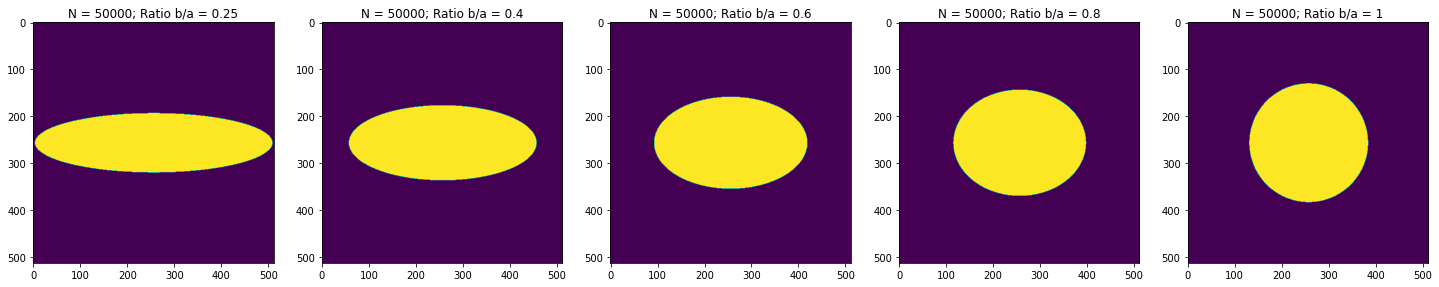

In [353]:
dataset1 = []

ratio_range = [0.25, 0.4, 0.6, 0.8, 1]

for ratio in ratio_range:
    ellipse = create_ellipsis(N=50000, ratio=ratio, intensity=intensity)
    dataset1.append(ellipse)

fig, ax = plt.subplots(1,5, figsize=(25, 5))

for i in range(len(ratio_range)):
    
    ratio = ratio_range[i]
    ell = dataset1[i]
    ax[i].imshow(ell)
    ax[i].set_title(f"N = {N}; Ratio b/a = {ratio}")
    
plt.savefig("Dataset1.pdf")
plt.show()

Completed in 0.78 seconds
Completed in 0.79 seconds
Completed in 0.65 seconds
Completed in 0.84 seconds
Completed in 0.73 seconds


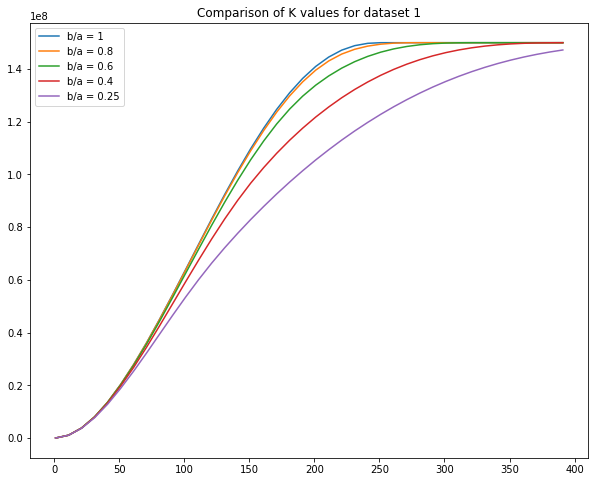

In [354]:
range_of_t = np.arange(1, 400, 10)

plt.figure(figsize=(10,8))
plt.title("Comparison of K values for dataset 1")

for i in reversed(range(len(ratio_range))):

    ratio = ratio_range[i]  # ratio of b and a axes of ellipse
    ell_img = dataset1[i]  # img of the ellipse
    
    total_int = np.sum(ell_img)
    # here A_pixel = 1  => N = A
    A = N
    _lambda = total_int / A
    
    K_values_cell = ripleys_K_fast(ell_img, range_of_t, _lambda)
    plt.plot(range_of_t, K_values_cell, label=f"b/a = {ratio}")
    
plt.legend()
plt.savefig("Kfunctions1.pdf")
plt.show()  

### Dataset 2: Ellipses with holes of different sizes

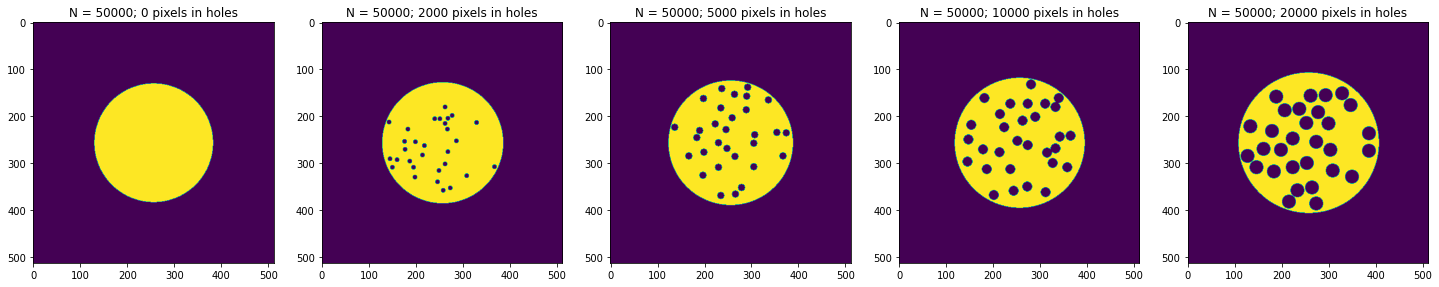

In [351]:
dataset2 = []

N_holes = 30
N_missing_range = [0, 2000, 5000, 10000, 20000]
#N_missing_range = [10000]

for N_missing in N_missing_range:
    ellipse = create_ellipsis(N=50000, N_holes=N_holes, N_missing=N_missing, intensity=intensity)
    dataset2.append(ellipse)

fig, ax = plt.subplots(1,5, figsize=(25, 5))


for i in range(len(N_missing_range)):
    
    N_missing = N_missing_range[i]
    ell = dataset2[i]
    ax[i].imshow(ell)
    ax[i].set_title(f"N = {N}; {N_missing} pixels in holes")
plt.savefig("dataset2.pdf")
plt.show()

Completed in 0.72 seconds
Completed in 0.64 seconds
Completed in 0.65 seconds
Completed in 0.65 seconds
Completed in 0.65 seconds


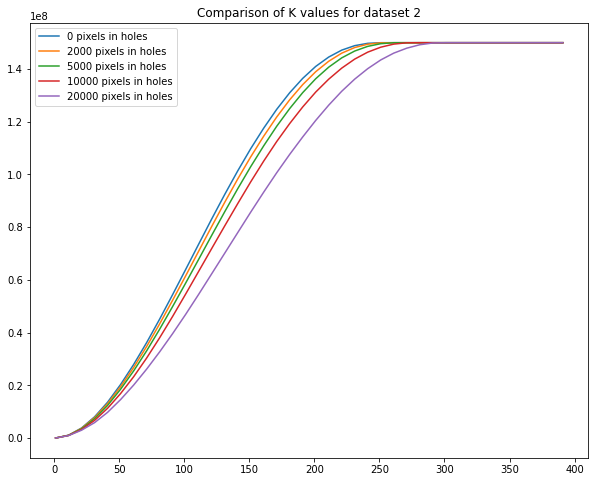

In [352]:
range_of_t = np.arange(1, 400, 10)

plt.figure(figsize=(10,8))
plt.title("Comparison of K values for dataset 2")

for i in range(len(N_missing_range)):
    
    N_missing = N_missing_range[i]  # ratio of b and a axes of ellipse
    ell_img = dataset2[i]  # img of the ellipse
    
    total_int = np.sum(ell_img)
    # here A_pixel = 1  => N = A
    A = N
    _lambda = total_int / A
    
    K_values_cell = ripleys_K_fast(ell_img, range_of_t, _lambda)
    plt.plot(range_of_t, K_values_cell, label=f"{N_missing} pixels in holes")
    
plt.legend()
plt.savefig("Kfunctions2.pdf")
plt.show()  

## Other tests

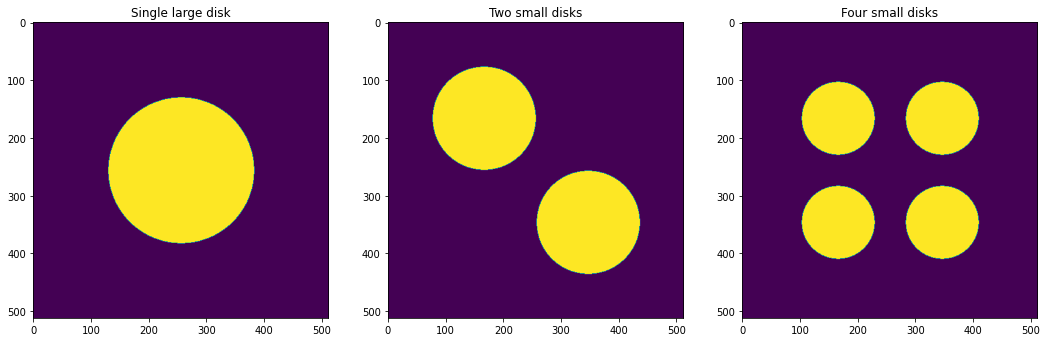

In [355]:
N1 = 50000
N2 = int(N1/2)
N3 = int(N1/4)
intensity = 3000

ell1 = create_ellipsis(N=N, intensity=intensity)
ell2a = create_ellipsis(N=N2, intensity=intensity, x_shift=90, y_shift=90)
ell2b = create_ellipsis(N=N2, intensity=intensity, x_shift=-90, y_shift=-90)
ell2 = ell2a + ell2b

ell3a = create_ellipsis(N=N3, intensity=intensity, x_shift=90, y_shift=90)
ell3b = create_ellipsis(N=N3, intensity=intensity, x_shift=-90, y_shift=-90)
ell3c = create_ellipsis(N=N3, intensity=intensity, x_shift=-90, y_shift=90)
ell3d = create_ellipsis(N=N3, intensity=intensity, x_shift=90, y_shift=-90)
ell3 = ell3a + ell3b + ell3c + ell3d


fix, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(ell1)
ax[0].set_title("Single large disk")
ax[1].imshow(ell2)
ax[1].set_title("Two small disks")
ax[2].imshow(ell3)
ax[2].set_title("Four small disks")
plt.savefig("Test1.pdf")
plt.show()

150063000.0 150198000.0 150204000.0
Completed in 0.73 seconds
Completed in 0.64 seconds
Completed in 0.62 seconds


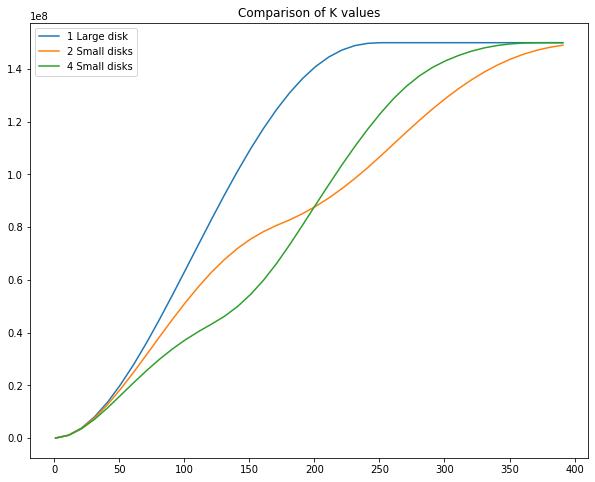

In [356]:
range_of_t = np.arange(1, 400, 10)

plt.figure(figsize=(10,8))
plt.title("Comparison of K values")


    
N_missing = N_missing_range[i]  # ratio of b and a axes of ellipse
ell_img = dataset2[i]  # img of the ellipse

total_int1 = np.sum(ell1)
total_int2 = np.sum(ell2)
total_int3 = np.sum(ell3)

print(total_int1, total_int2, total_int3)
# here A_pixel = 1  => N = A
A = N
_lambda1 = total_int1 / A
_lambda2 = total_int2 / A
_lambda3 = total_int3 / A

K_values1 = ripleys_K_fast(ell1, range_of_t, _lambda1)
K_values2 = ripleys_K_fast(ell2, range_of_t, _lambda2)
K_values3 = ripleys_K_fast(ell3, range_of_t, _lambda3)

plt.plot(range_of_t, K_values1, label="1 Large disk")
plt.plot(range_of_t, K_values2, label="2 Small disks")
plt.plot(range_of_t, K_values3, label="4 Small disks")
plt.legend()
plt.savefig("Result_Test1.pdf")
plt.show()